# Dataset Description

The dataset, 
[**Students: Germany, semester, nationality, sex, subject**](https://www-genesis.destatis.de/genesis//online?operation=table&code=21311-0003&bypass=true&levelindex=1&levelid=1714001036017#abreadcrumb), presented in this notebook provides a comprehensive overview of student statistics in Germany, detailing the number of students by semester, nationality, sex, and subject. 

## Key Features

- **Student Demographics**: The data includes a breakdown of students by gender, with separate counts for male and female students across various subjects.
- **Subject Diversity**: The dataset covers a wide range of 293 subjects, from areas like Waste Management and Egyptology to more conventional fields such as Agricultural Science and American Studies etc. and reflects the diverse academic interests pursued in Germany.
- **Semester-wise Distribution**: The statistics are organized by semester (WT 2022/23, WT 2021/22, WT 2020/21), offering insights into the enrollment trends over time.
- **Detailed Breakdown**: Each subject is listed with the total number of students, as well as the distribution between male and female students, providing a clear picture of gender representation in each academic field.

This dataset serves as a valuable resource for analyzing educational trends and gender distribution across different fields of study in Germany. It can be utilized for academic research, policy-making, and understanding the dynamics of higher education in the country.


In [16]:
# Necessary Libraries
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [5]:
# Load the data
df = pd.read_csv('data/21311-0003_$F.csv', sep=';', encoding='ISO-8859-1', skiprows=7,names=['semester', 'subject_code', 'subject_name', 'german_male', 'german_female', 'german_total', 'foreigner_male', 'foreigner_female', 'foreigner_total','male', 'female', 'total'])

In [6]:
df.head()

,semester,subject_code,subject_name,german_male,german_female,german_total,foreigner_male,foreigner_female,foreigner_total,male,female,total
0,WT 2020/21,SF141,Waste Management,53,26,79,2,-,2,55,26,81
1,WT 2020/21,SF002,African Studies,357,631,988,141,190,331,498,821,1319
2,WT 2020/21,SF138,Agricultural Biology,373,398,771,282,234,516,655,632,1287
3,WT 2020/21,SF125,Agricultural Economics,792,539,1331,359,240,599,1151,779,1930
4,WT 2020/21,SF003,Agricultural Science/Agriculture,7432,6966,14398,1143,1047,2190,8575,8013,16588


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882 entries, 0 to 881
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   semester          882 non-null    object
 1   subject_code      879 non-null    object
 2   subject_name      879 non-null    object
 3   german_male       879 non-null    object
 4   german_female     879 non-null    object
 5   german_total      879 non-null    object
 6   foreigner_male    879 non-null    object
 7   foreigner_female  879 non-null    object
 8   foreigner_total   879 non-null    object
 9   male              879 non-null    object
 10  female            879 non-null    object
 11  total             879 non-null    object
dtypes: object(12)
memory usage: 82.8+ KB


## 1. What are the trends in student enrollment across various fields of study?

In [14]:
# Trends in enrollment across fields
enroll_trends = df.groupby(['semester', 'subject_name'])[['german_total', 'foreigner_total']].sum().reset_index()
enroll_trends['total'] = enroll_trends['german_total'] + enroll_trends['foreigner_total']
enroll_trends = enroll_trends[['semester', 'subject_name', 'total']].sort_values(['semester', 'subject_name'])

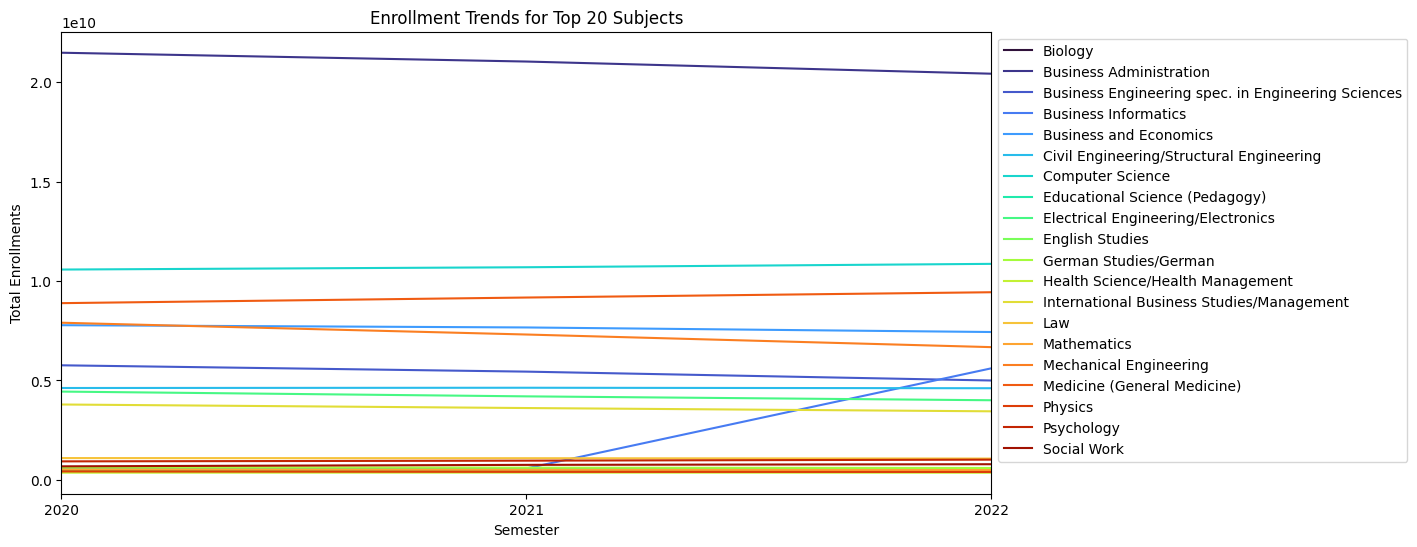

In [15]:
# Extract year and term from semester column
enroll_trends['year'] = enroll_trends['semester'].str.extract(r'(\d{4})', expand=False)
# Combine year and term into a new datetime column
enroll_trends['semester'] = pd.to_datetime(enroll_trends['year'], format='%Y')

# Convert 'total' column to numeric
enroll_trends['total'] = pd.to_numeric(enroll_trends['total'], errors='coerce')

# Get the top 20 subjects by total enrollments
top_subjects = enroll_trends.groupby('subject_name')['total'].sum().sort_values(ascending=False).head(20).index

# Filter the dataframe to include only the top 10 subjects
top_trends = enroll_trends[enroll_trends['subject_name'].isin(top_subjects)]

# Create a line plot for each of the top 20 subjects
fig, ax = plt.subplots(figsize=(12, 6))

# Define the colormap
cmap = matplotlib.colormaps['turbo']  

# Get the number of subjects
num_subjects = len(top_trends['subject_name'].unique())

for i, (subject, group) in enumerate(top_trends.groupby('subject_name')):
    color = cmap(i / num_subjects)  # Get the color from the colormap
    group.set_index('semester')['total'].plot(ax=ax, label=subject, color=color)

ax.set_xlabel('Semester')
ax.set_ylabel('Total Enrollments')
ax.set_title('Enrollment Trends for Top 20 Subjects')

# Place the legend outside of the plot on the right side
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

To answer these questions, we'll need to wrangle and analyze the data. 

1. Import necessary libraries (pandas, numpy, matplotlib, etc.)
2. Load the data into a pandas DataFrame
3. Check for missing values and clean/impute if needed
4. Convert data types (e.g. convert numeric strings to integers/floats)

Then for each specific question:

1. Trends in enrollment across fields:
    - Group the data by 'subject_name' and 'semester' 
    - Sum the 'total' column to get total enrollments
    - Plot the enrollments over time for each subject

2. Gender distribution across fields:
    - Group by 'subject_name'
    - Calculate percentage male/female for each subject
    - Visualize with a bar chart

3. Most popular subject for international students:
    - Sum the 'foreigner_total' column grouped by 'subject_name'
    - Identify the subject with the maximum value

4. Subjects popular by gender:
    - Sum the 'male' and 'female' columns grouped by 'subject_name'
    - Identify the top subjects for each gender 

5. Predicting future enrollments:
    - This would require analyzing trends over multiple past semesters
    - Time series methods like ARIMA could be used
    - But the data provided seems to only cover a single semester

